# RNA-Seq Count Normalization

**Created**: 18 December 2021

## Environment

In [1]:
if (!requireNamespace("BiocManager", quietly=TRUE)) {
    install.packages("BiocManager")
}

if (!require("limma", quietly=TRUE)) {
    BiocManager::install("limma")
}

if (!require("edgeR", quietly=TRUE)) {
    BiocManager::install("edgeR")
}

if (!require("Rtsne", quietly=TRUE)) {
    install.packages("Rtsne")
}

if (!require("UpSetR", quietly=TRUE)) {
    install.packages("UpSetR")
}

In [2]:
library(tidyverse)
library(data.table)
library(limma)
library(edgeR)
library(Rtsne)
library(parallel)
library(UpSetR)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




## Load Data

In [5]:
read.counts <- fread("~/gains_team282/epigenetics/accessibility/analysis/rna_seq/gene_counts.tsv")

In [6]:
head(read.counts)

Gene,Calderon-1001-Bulk_B-Control,Calderon-1001-Bulk_B-Treatment_1,Calderon-1001-CD8pos_T-Control,Calderon-1001-CD8pos_T-Treatment_1,Calderon-1001-Central_memory_CD8pos_T-Control,Calderon-1001-Central_memory_CD8pos_T-Treatment_1,Calderon-1001-Effector_CD4pos_T-Control,Calderon-1001-Effector_CD4pos_T-Treatment_1,Calderon-1001-Effector_memory_CD8pos_T-Control,⋯,Calderon-1010-Th17_precursors-Control,Calderon-1010-Th1_precursors-Control,Calderon-1010-Th2_precursors-Control,Calderon-1011-Monocytes-Treatment_2,Calderon-1011-Naive_B-Treatment_2,Calderon-1011-Naive_Teffs-Treatment_2,Corces-5852-Monocytes-Control,Corces-6792-Monocytes-Control,Corces-7256-Monocytes-Control,Corces-7653-Monocytes-Control
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000223972,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0
ENSG00000227232,13,13,6,11,15,0,17,3,45,⋯,0,2,0,1,3,3,2,3,0,2
ENSG00000278267,6,1,0,2,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000243485,0,0,0,0,0,1,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
ENSG00000284332,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [7]:
sample.info <- read.csv("03_Functional_Interpretation/metadata/reads_rna_seq.txt")

In [8]:
head(sample.info)

,Run,Group.ID,Sample.ID,Donor,Lineage,Cell_type,Stimulated,Treatment,Replicate,Assay.Type,⋯,Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,Sample.Name,source_name,SRA.Study
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<int>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,SRR2753094,Corces-5852-Monocytes-Control,Corces-5852-Monocytes-Control-1,Corces-5852,MYELOID,Monocytes,FALSE,Control,1,RNA-Seq,⋯,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1915599,Mono,SRP065216
2,SRR2753100,Corces-6792-Monocytes-Control,Corces-6792-Monocytes-Control-1,Corces-6792,MYELOID,Monocytes,FALSE,Control,1,RNA-Seq,⋯,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1915605,Mono,SRP065216
3,SRR2753109,Corces-7256-Monocytes-Control,Corces-7256-Monocytes-Control-1,Corces-7256,MYELOID,Monocytes,FALSE,Control,1,RNA-Seq,⋯,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1915614,Mono,SRP065216
4,SRR2753119,Corces-7653-Monocytes-Control,Corces-7653-Monocytes-Control-1,Corces-7653,MYELOID,Monocytes,FALSE,Control,1,RNA-Seq,⋯,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1915624,Mono,SRP065216
5,SRR11007061,Calderon-1001-CD8pos_T-Control,Calderon-1001-CD8pos_T-Control-1,Calderon-1001,CD8,CD8pos_T,FALSE,Control,1,RNA-Seq,⋯,Illumina NovaSeq 6000,PAIRED,cDNA,TRANSCRIPTOMIC,Homo sapiens,ILLUMINA,2020-02-04T00:00:00Z,GSM3319750,primary blood,SRP156452
6,SRR11007062,Calderon-1001-CD8pos_T-Treatment_1,Calderon-1001-CD8pos_T-Treatment_1-1,Calderon-1001,CD8,CD8pos_T,TRUE,Treatment_1,1,RNA-Seq,⋯,Illumina NovaSeq 6000,PAIRED,cDNA,TRANSCRIPTOMIC,Homo sapiens,ILLUMINA,2020-02-04T00:00:00Z,GSM3319751,primary blood,SRP156452


In [31]:
qc <- read.table("~/gains_team282/epigenetics/accessibility/analysis/rna_seq/rnaseqc.tsv", sep="\t", quote=c(), header=T, row.names=1, check.names=F)

qc <- as.data.frame(t(qc)) %>%
    dplyr::mutate(Group.ID=rownames(.)) %>%
    dplyr::select(Group.ID, everything())

colnames(qc) <- make.names(colnames(qc))

In [32]:
head(qc)

,Group.ID,Mapping.Rate,Unique.Rate.of.Mapped,Duplicate.Rate.of.Mapped,Duplicate.Rate.of.Mapped..excluding.Globins,Base.Mismatch,End.1.Mapping.Rate,End.2.Mapping.Rate,End.1.Mismatch.Rate,End.2.Mismatch.Rate,⋯,Median.3..bias,X3..bias.Std,X3..bias.MAD_Std,X3..Bias..25th.Percentile,X3..Bias..75th.Percentile,Median.of.Avg.Transcript.Coverage,Median.of.Transcript.Coverage.Std,Median.of.Transcript.Coverage.CV,Median.Exon.CV,Exon.CV.MAD
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Calderon-1003-Regulatory_T-Control,Calderon-1003-Regulatory_T-Control,1,0.417506,0.582494,0.582494,0,0,0,NaN,NaN,⋯,0.512629,0.366025,0.581744,0.1810340,0.957447,0.0000000,0.000000,3.27850,0.847009,1.062230
Calderon-1004-CD8pos_T-Treatment_1,Calderon-1004-CD8pos_T-Treatment_1,1,0.513875,0.486125,0.486127,0,0,0,NaN,NaN,⋯,0.480000,0.323368,0.434766,0.1851850,0.772414,0.0000000,0.000000,1.80903,0.292417,0.336902
Calderon-1009-Mature_NK-Treatment_2,Calderon-1009-Mature_NK-Treatment_2,1,0.550788,0.449212,0.449212,0,0,0,NaN,NaN,⋯,0.309569,0.326591,0.373401,0.0909091,0.648148,0.0000000,0.000000,2.93805,0.544710,0.601185
Calderon-1010-Monocytes-Treatment_2,Calderon-1010-Monocytes-Treatment_2,1,0.664773,0.335227,0.335227,0,0,0,NaN,NaN,⋯,0.536648,0.370326,0.611256,0.2074200,0.967480,0.0458996,0.257737,3.96029,1.603610,1.256850
Calderon-1001-Naive_CD8_T-Control,Calderon-1001-Naive_CD8_T-Control,1,0.556475,0.443525,0.443526,0,0,0,NaN,NaN,⋯,0.333333,0.309379,0.375817,0.1038960,0.636364,0.0000000,0.000000,1.68668,0.293975,0.299127
Calderon-1001-Memory_Teffs-Control,Calderon-1001-Memory_Teffs-Control,1,0.563167,0.436833,0.436834,0,0,0,NaN,NaN,⋯,0.331514,0.308688,0.373347,0.0960452,0.621469,0.0000000,0.000000,1.50305,0.282169,0.284696


## Limma-Voom Modeling

### Count Matrix

Set up the count matrix in the format required for Limma.

In [21]:
count.mtx <- as.matrix(read.counts[,-1])
rownames(count.mtx) <- read.counts$Gene

In [22]:
head(count.mtx)

,Calderon-1001-Bulk_B-Control,Calderon-1001-Bulk_B-Treatment_1,Calderon-1001-CD8pos_T-Control,Calderon-1001-CD8pos_T-Treatment_1,Calderon-1001-Central_memory_CD8pos_T-Control,Calderon-1001-Central_memory_CD8pos_T-Treatment_1,Calderon-1001-Effector_CD4pos_T-Control,Calderon-1001-Effector_CD4pos_T-Treatment_1,Calderon-1001-Effector_memory_CD8pos_T-Control,Calderon-1001-Effector_memory_CD8pos_T-Treatment_1,⋯,Calderon-1010-Th17_precursors-Control,Calderon-1010-Th1_precursors-Control,Calderon-1010-Th2_precursors-Control,Calderon-1011-Monocytes-Treatment_2,Calderon-1011-Naive_B-Treatment_2,Calderon-1011-Naive_Teffs-Treatment_2,Corces-5852-Monocytes-Control,Corces-6792-Monocytes-Control,Corces-7256-Monocytes-Control,Corces-7653-Monocytes-Control
ENSG00000223972,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0
ENSG00000227232,13,13,6,11,15,0,17,3,45,10,⋯,0,2,0,1,3,3,2,3,0,2
ENSG00000278267,6,1,0,2,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000243485,0,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
ENSG00000284332,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [23]:
filtered.samples <- qc$Run[qc$Mapped.Reads > 1e7]
count.mtx <- count.mtx[, filtered.samples]

In [24]:
dim(count.mtx)

[1] 60676   169

### Create Sample Groups

The samples are grouped using cell type and treatment condition. The cell type and treatment group for each sample is stored in `groups`.

In [38]:
cell.type <- sample.info[match(colnames(count.mtx), sample.info$Group.ID), "Cell_type"]
stimulated <- ifelse(sample.info[match(colnames(count.mtx), sample.info$Group.ID), "Stimulated"] == FALSE, "Baseline", "Stimulated")
groups <- interaction(cell.type, stimulated, sep="_")
groups <- droplevels(groups)

I will also be normalizing the data by removing batch effects. The donor is used as a categorical batch.

In [40]:
donors <- factor(sample.info[match(colnames(count.mtx), sample.info$Group.ID), "Donor"])
donors <- droplevels(donors)

The design matrix indicates which samples belong to which groups.

In [42]:
design <- model.matrix(~0 + groups + donors)

### Create DGEList

`edgeR` can be used to handle count matrices. We will use `voom` in the next step to process this `edgeR` object.

In [43]:
dge <- DGEList(count.mtx)

Filter genes using in-built `edgeR` function.

In [44]:
keep <- filterByExpr(dge, group=groups)
dge <- dge[keep, , keep.lib.sizes=FALSE]

In [45]:
dim(dge)

[1] 47211   169

Calculate normalization factors for the trimmed mean of M-values method.

In [46]:
dge <- calcNormFactors(dge, method="TMM")

### Voom

`voom` models a count matrix by empirically identifying the mean-variance relationship within the data. The count matrix can then be normalized and batch effects can be removed. The normalized data can be used in downstream analysis with `limma`.

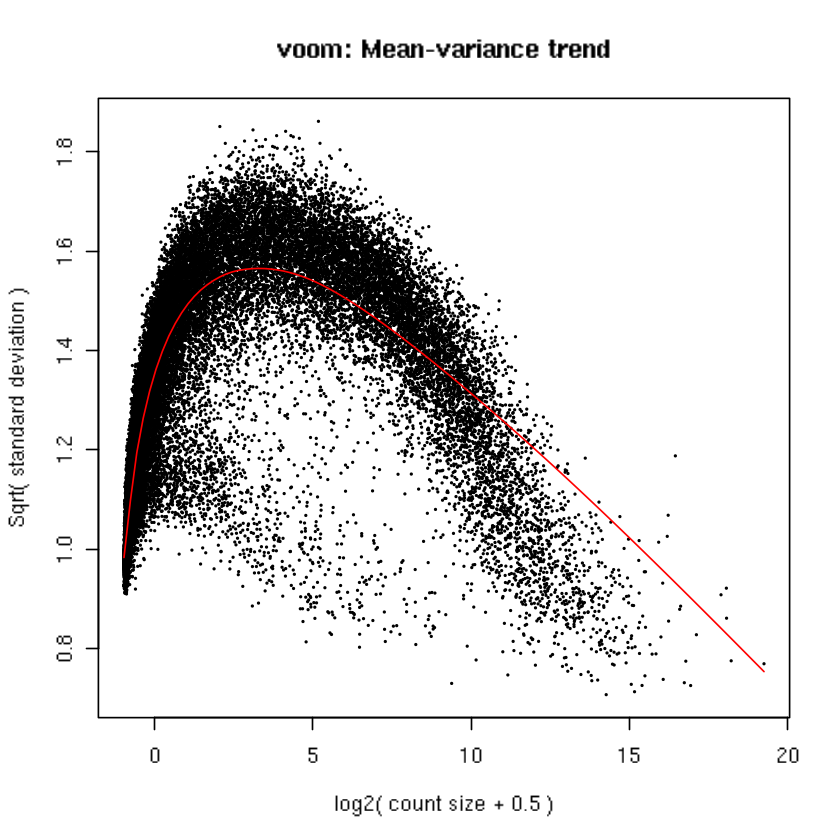

In [47]:
y <- voom(dge, design, plot=TRUE)

### Visualize Normalized Counts

In [48]:
pca <- prcomp(t(as.matrix(y)))

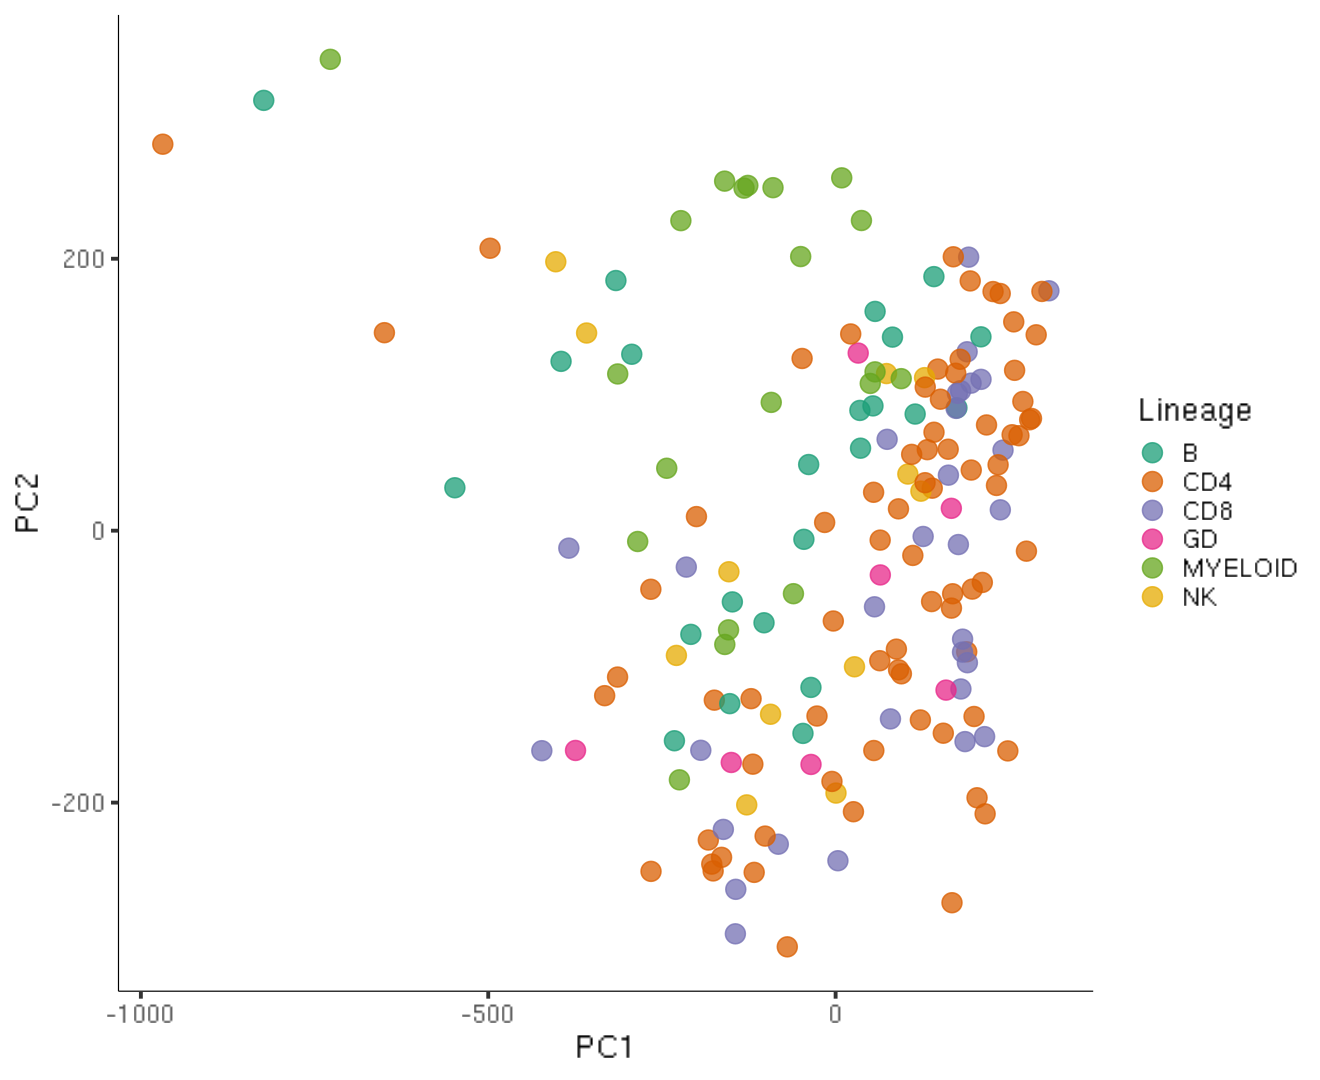

In [52]:
options(repr.plot.width=11, repr.plot.height=9)

merge(pca$x, sample.info, by.x=0, by.y="Group.ID") %>%
    as.data.frame() %>%
    ggplot() +
    geom_point(aes(x=PC1, y=PC2, color=Lineage), size=I(5), alpha=0.75) +
    scale_color_brewer(palette="Dark2") +
    labs(color="Lineage") +
    ggplot_theme +
    theme(legend.position="right")

ggsave("03_Functional_Interpretation/results/normalized_read_count_pca.svg", width=8, height=9)

In [53]:
set.seed(9873945)
tsne.res <- Rtsne(t(as.matrix(y)[,stimulated == "Baseline"]), num_threads=4, perplexity=5)

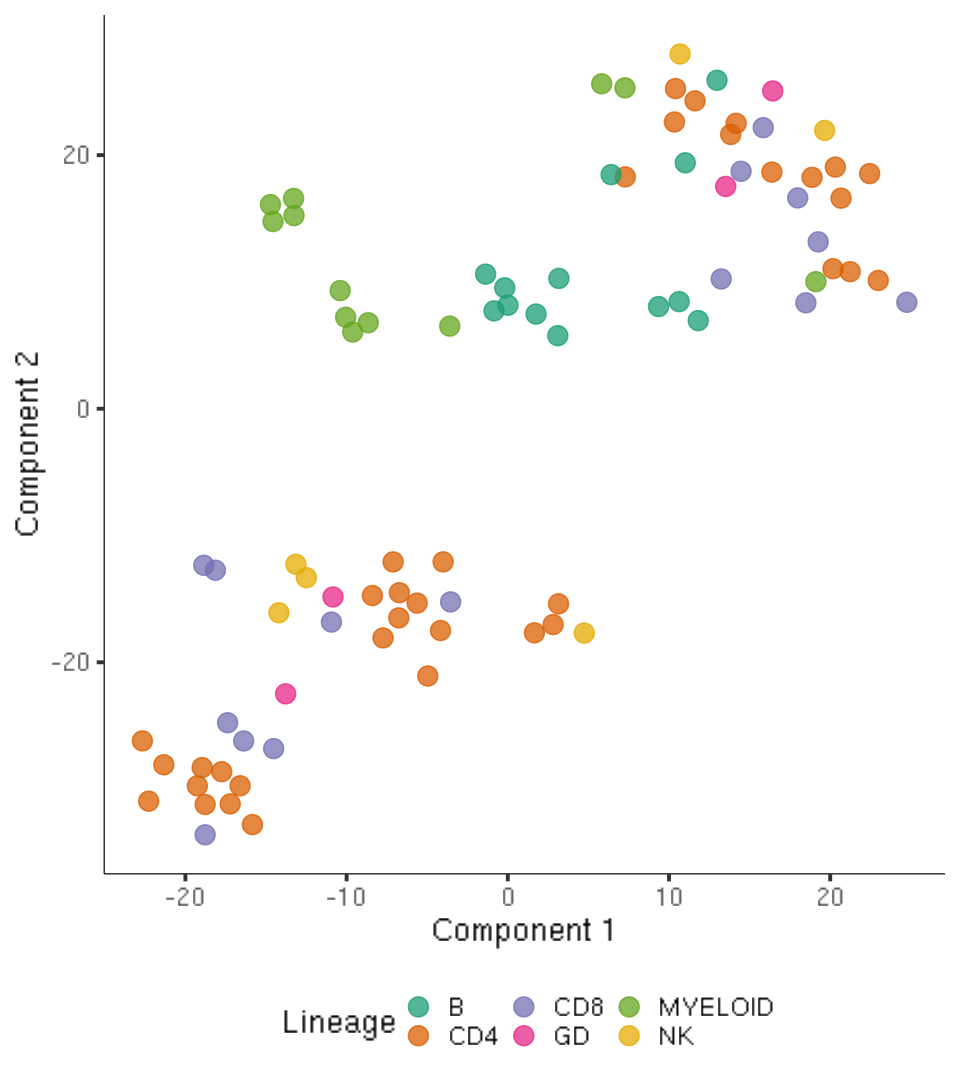

In [55]:
options(repr.plot.width=8, repr.plot.height=9)

tsne.res$Y %>%
    as.data.frame() %>%
    dplyr::select(Comp1=1, Comp2=2) %>%
    dplyr::mutate(Group.ID=colnames(as.matrix(y)[,stimulated == "Baseline"])) %>%
    merge(., sample.info, by="Group.ID") %>%
    ggplot() +
    geom_point(aes(x=Comp1, y=Comp2, color=Lineage), size=I(5), alpha=0.75) +
    scale_color_brewer(palette="Dark2") +
    xlab("Component 1") + ylab("Component 2") +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/normalized_read_count_tsne.svg", width=8, height=9)

### Limma

Use `limma` to fit a linear model consisting of the biological `groups`.

In [56]:
fit <- lmFit(y, design)

### Limma DE Genes

Identify all cell types where both the baseline and stimulated conditions are present.

In [57]:
cell.type.conditions <- cbind(cell.type, stimulated) %>%
    as.data.frame() %>%
    dplyr::select(Cell.Type=1, Stimulated=2) %>%
    dplyr::group_by(Cell.Type, Stimulated) %>%
    dplyr::summarize(N=n(), .groups="drop") %>%
    tidyr::spread(Stimulated, N) %>%
    na.omit()

Create contrasts for each cell type that has both baseline and stimulated conditions.

In [58]:
contrast <- matrix(0, nrow=ncol(coef(fit)), ncol=nrow(cell.type.conditions))
rownames(contrast) <- colnames(coef(fit))
colnames(contrast) <- paste0(cell.type.conditions$Cell.Type, "_Stimulated-", cell.type.conditions$Cell.Type, "_Baseline")

for (i in 1:nrow(cell.type.conditions)) {
    cell.type.condition = cell.type.conditions$Cell.Type[i]
    contrast[paste0("groups", cell.type.condition, "_Stimulated"), i] = 1
    contrast[paste0("groups", cell.type.condition, "_Baseline"), i] = -1
}

In [59]:
de.genes <- rbindlist(lapply(1:ncol(contrast), function(i) {
    de.res = eBayes(contrasts.fit(fit, contrast[,i]))
    de.res.table = topTable(de.res, sort.by="p", n=Inf)
    
    contrast.cell.type = strsplit(colnames(contrast)[i], "-")[[1]][1]
    contrast.cell.type = substr(contrast.cell.type, start=1, stop=nchar(contrast.cell.type) - 11)

    de.res.table %>%
        dplyr::mutate(Contrast=colnames(contrast)[i]) %>%
        dplyr::mutate(Cell.Type=contrast.cell.type) %>%
        dplyr::mutate(Gene.ID=rownames(.)) %>%
        dplyr::select(Contrast, Cell.Type, Gene.ID, logFC, AveExpr, t, P.Value, adj.P.Val, B)
}))

## Differentially Expressed Genes

Calculate differentially expressed genes. For each contrast, a peak is considered differentially accessible if the adjusted P-value is < 0.01 and the absolute log fold change is greater than 1.

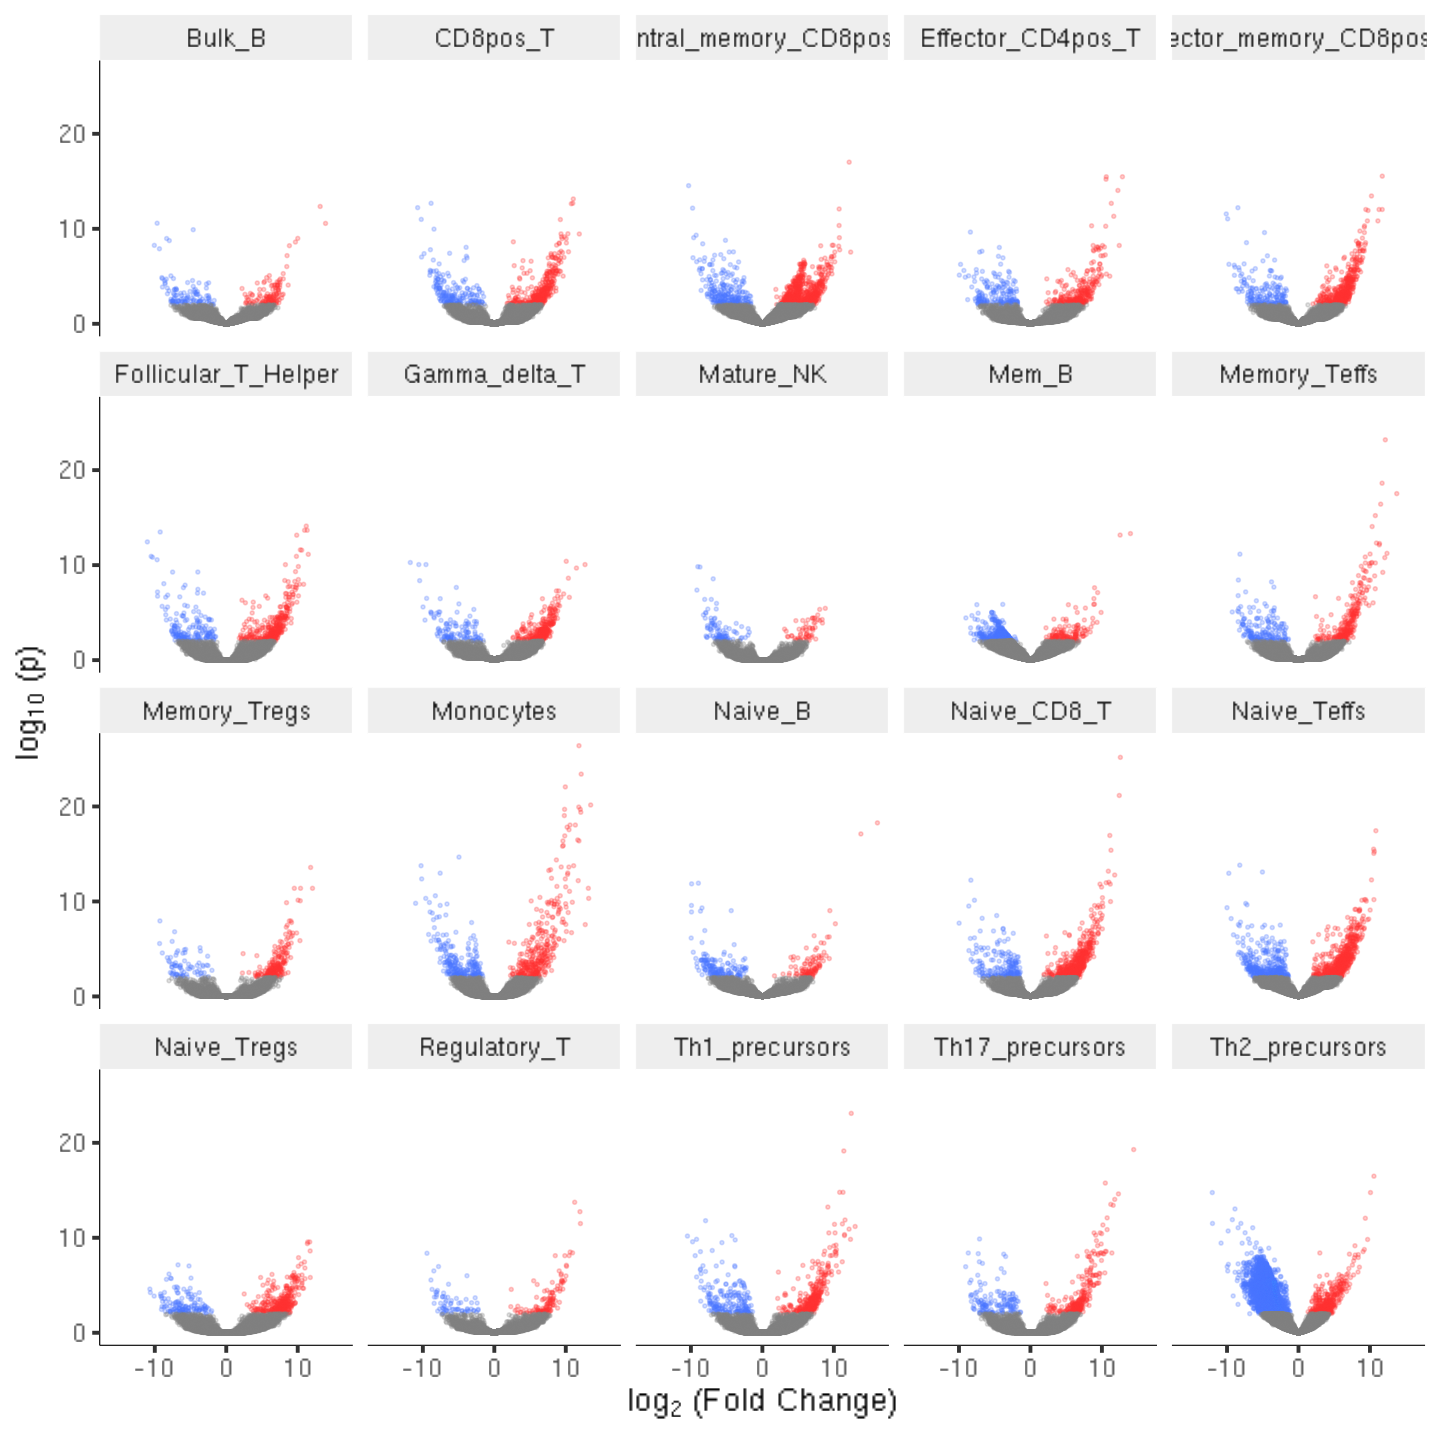

In [60]:
options(repr.plot.width=12, repr.plot.height=12)

abs.max.log.fc <- max(abs(de.genes$logFC))

de.genes %>%
    dplyr::mutate(log.adj.P.Val=-log10(adj.P.Val)) %>%
    dplyr::mutate(Accessible=ifelse(adj.P.Val < 0.01 & logFC > 1, "More", ifelse(adj.P.Val < 0.01 & logFC < -1, "Less", "Same"))) %>%
    ggplot() +
    geom_point(aes(x=logFC, y=log.adj.P.Val, color=Accessible), size=I(0.5), alpha=0.25) +
    scale_color_manual(values=c("More"="firebrick1", "Less"="royalblue1")) +
    guides(color="none") +
    facet_wrap(vars(Cell.Type)) +
    xlim(-abs.max.log.fc, abs.max.log.fc) +
    xlab(bquote("log"[2]~"(Fold Change)")) + ylab(bquote("log"[10]~"(p)")) +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/de_genes_volcano_plots.png", width=12, height=12)

In [61]:
de.genes.set <- de.genes %>%
    dplyr::filter(abs(logFC) > 1) %>%
    dplyr::filter(adj.P.Val < 0.01)

write.csv(de.genes.set, "~/gains_team282/epigenetics/calderon_et_al/analysis/rna_seq/de_genes_set.csv")

There are 31,073 unique DE genes across all contrasts.

In [62]:
length(unique(de.genes.set$Gene.ID))

[1] 32578

In [63]:
length(unique(de.genes.set$Gene.ID[de.genes.set$Cell.Type != "Th2_precursors"]))

[1] 5335